# **X-Ray Image Classification with 🤗 Swin Transformers**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Swin Base model
model_checkpoint = "microsoft/swin-base-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 16 # batch size for training and evaluation

In [3]:
!pip install -q datasets transformers accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from huggingface_hub import notebook_login
notebook_login()

## Fine-tuning a model on an X-ray image classification task

### Loading the dataset

In [5]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/49275-nn-fuzzy-logic/xray-classification/data")

Resolving data files:   0%|          | 0/4370 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/545 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/550 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4370
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 545
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 550
    })
})

In [7]:
example = dataset["train"][10]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512>,
 'label': 0}

In [8]:
dataset["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Atelectasis', 'Cardiomegaly', 'No Finding', 'Nodule', 'Pneumothorax'], id=None)}

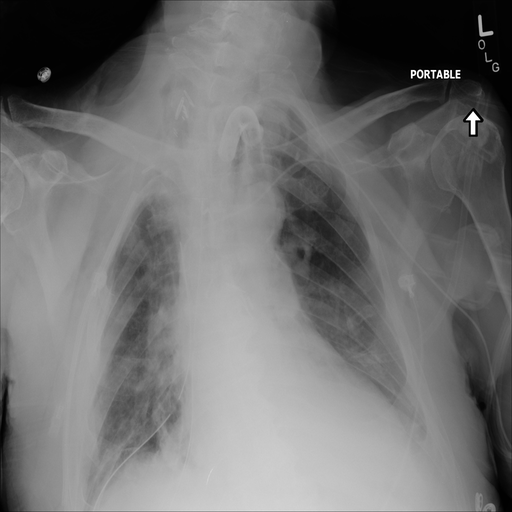

In [9]:
example['image']

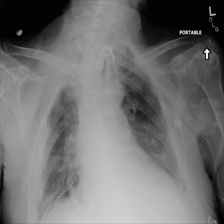

In [10]:
example['image'].resize((224, 224))

In [11]:
example['label']

0

In [12]:
dataset["train"].features["label"]

ClassLabel(names=['Atelectasis', 'Cardiomegaly', 'No Finding', 'Nodule', 'Pneumothorax'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [13]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'No Finding'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called an image processor with the `AutoImageProcessor.from_pretrained` method.

This image processor is a minimal preprocessor that can be used to prepare images for inference.

In [14]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [15]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    RandomRotation,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            # RandomHorizontalFlip(p=0.5),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [16]:
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]

In [17]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [18]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512>,
 'label': 0,
 'pixel_values': tensor([[[1.0502, 1.0673, 1.0159,  ..., 1.0502, 1.0159, 1.0159],
          [1.0331, 1.0673, 1.0331,  ..., 1.0673, 1.0673, 1.0331],
          [1.0159, 1.0331, 0.9988,  ..., 1.0502, 1.0673, 1.0673],
          ...,
          [1.7180, 1.7009, 1.7180,  ..., 0.9817, 0.9817, 0.9646],
          [1.7009, 1.6838, 1.7009,  ..., 0.9817, 0.9817, 0.9817],
          [1.7180, 1.7009, 1.7352,  ..., 1.0159, 1.0159, 0.9817]],
 
         [[1.2031, 1.2206, 1.1681,  ..., 1.2031, 1.1681, 1.1681],
          [1.1856, 1.2206, 1.1856,  ..., 1.2206, 1.2206, 1.1856],
          [1.1681, 1.1856, 1.1506,  ..., 1.2031, 1.2206, 1.2206],
          ...,
          [1.8859, 1.8683, 1.8859,  ..., 1.1331, 1.1331, 1.1155],
          [1.8683, 1.8508, 1.8683,  ..., 1.1331, 1.1331, 1.1331],
          [1.8859, 1.8683, 1.9034,  ..., 1.1681, 1.1681, 1.1331]],
 
         [[1.4200, 1.4374, 1.3851,  ..., 1.4200, 1.3851, 1.3851],
      

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

In [19]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

In [20]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/49275-nn-fuzzy-logic/xray-classification/{model_name}-finetuned-xray",  # ✅ Save to local folder
    # f"{model_name}-xray",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=50,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    #push_to_hub=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
from evaluate import load

# Load the metric
precision = load("precision")
recall = load("recall")
f1 = load("f1")
accuracy = load("accuracy")

In [22]:
import numpy as np

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "precision": precision.compute(predictions=preds, references=p.label_ids, average="macro")["precision"],
        "recall": recall.compute(predictions=preds, references=p.label_ids, average="macro")["recall"],
        "f1": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"],
    }

In [23]:
"""import numpy as np
metric = load("accuracy")

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    # Computes accuracy on a batch of predictions
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)"""

'import numpy as np\nmetric = load("accuracy")\n\n# the compute_metrics function takes a Named Tuple as input:\n# predictions, which are the logits of the model as Numpy arrays,\n# and label_ids, which are the ground-truth labels as Numpy arrays.\ndef compute_metrics(eval_pred):\n    # Computes accuracy on a batch of predictions\n    predictions = np.argmax(eval_pred.predictions, axis=1)\n    return metric.compute(predictions=predictions, references=eval_pred.label_ids)'

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [24]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Now we can finetune our model by calling the `train` method:

In [27]:
train_results = trainer.train()
trainer.save_model()
# trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
# trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.497500,1.449073,0.383486,0.388387,0.383486,0.365823
2,1.461300,1.346920,0.427523,0.488344,0.427523,0.391935
3,1.331900,1.225982,0.504587,0.471054,0.504587,0.458170
4,1.291300,1.219800,0.532110,0.597206,0.532110,0.512415
5,1.272300,1.198662,0.513761,0.546268,0.513761,0.491121
6,1.217700,1.284144,0.511927,0.613172,0.511927,0.486976
7,1.196300,1.197750,0.508257,0.540291,0.508257,0.478874
8,1.078200,1.072145,0.565138,0.572868,0.565138,0.556172
9,1.149500,1.214610,0.537615,0.572390,0.537615,0.513132
10,0.988800,1.217292,0.524771,0.595804,0.524771,0.511293


Epoch,Training Loss,Validation Loss


Could not locate the best model at /content/drive/MyDrive/49275-nn-fuzzy-logic/xray-classification/swin-base-patch4-window7-224-finetuned-xray/checkpoint-1725/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/49275-nn-fuzzy-logic/xray-classification/swin-base-patch4-window7-224-finetuned-xray/checkpoint-1725'

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [28]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.497500,1.449073,0.383486,0.388387,0.383486,0.365823
2,1.461300,1.346920,0.427523,0.488344,0.427523,0.391935
3,1.331900,1.225982,0.504587,0.471054,0.504587,0.458170
4,1.291300,1.219800,0.532110,0.597206,0.532110,0.512415
5,1.272300,1.198662,0.513761,0.546268,0.513761,0.491121
6,1.217700,1.284144,0.511927,0.613172,0.511927,0.486976
7,1.196300,1.197750,0.508257,0.540291,0.508257,0.478874
8,1.078200,1.072145,0.565138,0.572868,0.565138,0.556172
9,1.149500,1.214610,0.537615,0.572390,0.537615,0.513132
10,0.988800,1.217292,0.524771,0.595804,0.524771,0.511293


***** eval metrics *****
  eval_accuracy  = 0.5853
  eval_f1        =  0.587
  eval_loss      = 1.9244
  eval_precision = 0.5901
  eval_recall    = 0.5853


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# This will return predictions and true labels
predictions_output = trainer.predict(val_ds)

# Get predicted class labels
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.497500,1.449073,0.383486,0.388387,0.383486,0.365823
2,1.461300,1.346920,0.427523,0.488344,0.427523,0.391935
3,1.331900,1.225982,0.504587,0.471054,0.504587,0.458170
4,1.291300,1.219800,0.532110,0.597206,0.532110,0.512415
5,1.272300,1.198662,0.513761,0.546268,0.513761,0.491121
6,1.217700,1.284144,0.511927,0.613172,0.511927,0.486976
7,1.196300,1.197750,0.508257,0.540291,0.508257,0.478874
8,1.078200,1.072145,0.565138,0.572868,0.565138,0.556172
9,1.149500,1.214610,0.537615,0.572390,0.537615,0.513132
10,0.988800,1.217292,0.524771,0.595804,0.524771,0.511293


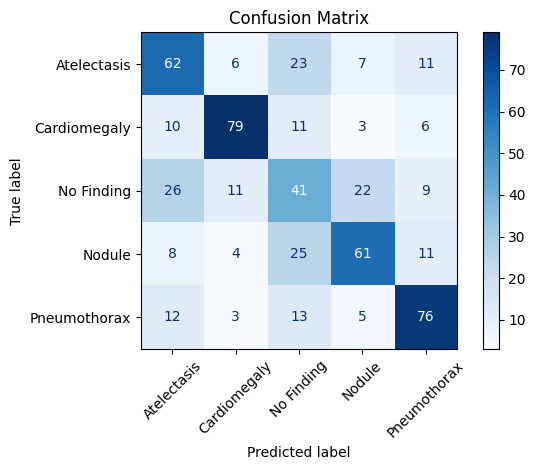

Validation accuracy: {'accuracy': 0.5853211009174312}


<Figure size 640x480 with 0 Axes>

In [30]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
acc = accuracy.compute(predictions=y_pred, references=y_true)

# Get class labels from the model config
labels = list(model.config.id2label.values()) if hasattr(model.config, 'id2label') else None

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()
print("Validation accuracy:", acc)
plt.savefig("/content/drive/MyDrive/49275-nn-fuzzy-logic/xray-classification/confusion_matrix.png")

# End of the Notebook